# NOTE: CODE NEEDS TO BE RUN IN ORDER

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.feature_selection import f_regression, mutual_info_regression 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import ensemble

In [3]:
housing = pd.read_csv('./data/Ames_HousePrice.csv', index_col=0)
housing['LogSalePrice'] = np.log(housing['SalePrice'])
pd.set_option('display.max_columns', housing.shape[1])
addl_features = pd.read_csv('./data/nn_sales2_data.csv')[['PID', 'nn5meansaleprice', 'nn5medsaleprice']]
housing = pd.merge(housing, addl_features, on = 'PID')
housing['nn5meansaleprice'] = np.log(housing['nn5meansaleprice'])
housing['nn5medsaleprice'] = np.log(housing['nn5medsaleprice'])
housing.sample(10)

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,LogSalePrice,nn5meansaleprice,nn5medsaleprice
194,907420090,1310,164990,20,RL,65.0,8767,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,7,5,2005,2005,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,Av,GLQ,24.0,Unf,0.0,1286.0,1310.0,...,Y,SBrkr,1310,0,0,0.0,0.0,2,0,3,1,Gd,6,Typ,1,Gd,Attchd,2005.0,Fin,2.0,400.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,7,2006,New,Partial,12.013640,12.151269,12.149502
1105,528102140,2772,462000,60,RL,110.0,14257,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,PosN,Norm,1Fam,2Story,9,5,2007,2007,Hip,CompShg,VinylSd,VinylSd,Stone,726.0,Ex,TA,PConc,Ex,TA,No,GLQ,1360.0,Unf,0.0,416.0,1776.0,...,Y,SBrkr,1794,978,0,1.0,0.0,3,1,4,1,Ex,10,Typ,3,Gd,BuiltIn,2007.0,Fin,3.0,754.0,TA,TA,Y,135,64,0,0,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal,13.043320,13.053948,13.021327
1253,534276190,1014,98000,20,RL,74.0,7785,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,5,1956,1956,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,...,Y,SBrkr,1014,0,0,0.0,0.0,1,0,2,1,TA,6,Typ,0,NaN,Attchd,1956.0,RFn,1.0,267.0,TA,TA,Y,0,0,40,0,200,0,NaN,GdWo,NaN,0,3,2008,WD,Normal,11.492723,11.755872,11.728037
1772,535177100,1336,162000,20,RL,NaN,9610,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Feedr,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,632.0,TA,TA,CBlock,TA,TA,No,Rec,203.0,Unf,0.0,918.0,1121.0,...,Y,FuseA,1336,0,0,0.0,0.0,1,1,3,1,TA,7,Typ,1,TA,Attchd,1958.0,RFn,2.0,488.0,TA,TA,Y,80,0,0,0,0,0,NaN,NaN,NaN,0,12,2006,WD,Normal,11.995352,11.981240,12.019743
1545,533252130,1437,218000,20,RL,90.0,10768,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Veenker,Norm,Norm,1Fam,1Story,5,8,1976,2004,Gable,CompShg,Plywood,Plywood,None,0.0,Gd,Gd,CBlock,Gd,TA,Gd,ALQ,1157.0,Unf,0.0,280.0,1437.0,...,Y,SBrkr,1437,0,0,1.0,0.0,2,0,3,1,Gd,6,Typ,1,Fa,Attchd,1976.0,RFn,2.0,528.0,TA,TA,Y,0,21,0,0,180,0,NaN,NaN,NaN,0,7,2007,WD,Normal,12.292250,12.295776,12.138864
328,528110100,2643,380000,60,RL,105.0,13693,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,2Story,9,5,2006,2006,Hip,CompShg,VinylSd,VinylSd,BrkFace,772.0,Ex,TA,PConc,Gd,TA,Av,Unf,0.0,Unf,0.0,2153.0,2153.0,...,Y,SBrkr,2069,574,0,0.0,0.0,2,1,3,1,Ex,9,Typ,1,Gd,BuiltIn,2006.0,Fin,3.0,694.0,TA,TA,Y,414,84,0,0,0,0,NaN,NaN,NaN,0,3,2007,WD,Normal,12.847927,12.976247,12.942040
229,909253190,790,91000,30,RL,52.0,6292,Pave,NaN,Reg,Bnk,AllPub,Inside,Gtl,SWISU,Norm,Norm,1Fam,1Story,6,5,1930,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,Gd,TA,Mn,Rec,384.0,Unf,0.0,384.0,768.0,...,N,SBrkr,790,0,0,0.0,0.0,1,0,2,1,TA,4,Typ,0,NaN,Detchd,1925.0,Unf,1.0,160.0,Fa,TA,Y,0,141,0,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Normal,11.418615,11.891293,11.845820
2348,905426030,1518,260000,30,RL,85.0,19550,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1940,2007,Flat,Tar&Grv,PreCast,PreCast,None,0.0,TA,TA,PConc,TA,TA,Gd,ALQ,1035.0,Unf,0.0,545.0,1580.0,...,Y,SBrkr,1518,0,0,1.0,0.0,1,0,2,1,Fa,5,Typ,2,Gd,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,39,0,0,0,0,NaN,NaN,NaN,0,1,2008,WD,Normal,12.468437,12.386726,12.388394
434,533206040,1143,176400,120,FV,34.0,3628,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,TwnhsE,1S

In [83]:
def dummify(dataframe, column):
    """Dummifies the given column in the given dataframe and drops the class with the highest frequency of occurence. 
    Returns the original dataframe with the given column dropped and dummified columns added"""
    temp = pd.get_dummies(dataframe[~dataframe[column].isnull()][column], prefix = column)
    temp.drop(column + '_' + str(dataframe[~dataframe[column].isnull()][column].mode()[0]), axis = 1, inplace = True)
    dataframe = dataframe[~dataframe[column].isnull()].drop(column, axis = 1)
    dataframe = pd.concat([dataframe, temp], axis = 1)
    return dataframe

# Initial Features Selection Based On Qualitative EDA

In [4]:
# Primary: (MSSubClass, HouseStyle, BldgType), MsZoning, LotArea, LandContour, LotConfig, Neighborhood, Condition1,
# YearBuilt, YearRemodAdd (binary categorical variable of 1 or 0 on remodeling), RoofStyle, (Exterior1st, Exterior2nd, 
# MasVnrType, MasVnrArea, ExterQual, ExterCond), Foundation, (BsmtQual, BsmtCond, BsmtFinType1, BsmtFinSF1, TotalBsmtSF),
# HeatingQC, CentralAir, Electrical, (1stFlrSF, 2ndFlrSF, GrLivArea), (BsmtFullBath, FullBath, HalfBath), (BedroomAbvGr,
# TotRmsAbvGrd), KitchenQual, Fireplaces, (GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual,
# GarageCond, PavedDrive), MoSold, SaleType, SaleCondition

# Features After Unary F-tests and Mutual Information

In [84]:
housing_temp = housing.copy()
housing_temp.drop(['PID', 'SalePrice', 'LotFrontage'], axis = 1, inplace= True)

housing_temp['YearRemodAdd'] = (housing_temp['YearBuilt'] != housing_temp['YearRemodAdd']).map(int)

cat_features_with_NA = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
                   'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
for feature in cat_features_with_NA:
    housing_temp[feature].fillna('NA', inplace = True)
housing_temp = housing_temp[~housing_temp.isnull().any(axis = 1)]

features_to_be_dummified = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
                            'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                            'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
                            'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                            'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
                            'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
                            'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
for column in features_to_be_dummified:
    housing_temp = dummify(housing_temp, column)

value_f, p_f = f_regression(housing_temp.loc[:, housing_temp.columns != 'LogSalePrice'], housing_temp['LogSalePrice'])
mutual_scores = mutual_info_regression(housing_temp.loc[:, housing_temp.columns != 'LogSalePrice'],
                                       housing_temp['LogSalePrice'])

In [85]:
p_values = pd.Series(p_f, index = housing_temp.loc[:, housing_temp.columns != 'LogSalePrice'].columns).sort_values()
pd.DataFrame(p_values.head(25), columns = ['p-values'])

,p-values
GrLivArea,0.000000e+00
nn5meansaleprice,0.000000e+00
nn5medsaleprice,0.000000e+00
GarageCars,1.311378e-280
TotalBsmtSF,6.154657e-277
1stFlrSF,5.149741e-260
GarageArea,6.146873e-248
YearBuilt,5.525248e-226
FullBath,1.320293e-213
GarageYrBlt,1.286786e-204


In [86]:
mutual_score_values = pd.Series(mutual_scores, 
        index = housing_temp.loc[:, housing_temp.columns != 'LogSalePrice'].columns).sort_values(ascending = False)
pd.DataFrame(mutual_score_values.head(25), columns = ['mutual information scores'])

,mutual information scores
nn5meansaleprice,0.701459
nn5medsaleprice,0.682524
GrLivArea,0.486130
TotalBsmtSF,0.391405
YearBuilt,0.379542
1stFlrSF,0.356840
GarageArea,0.354823
GarageCars,0.339547
GarageYrBlt,0.277777
FullBath,0.257755


# Features After Comparing R2 From Simple Linear Regression 

In [8]:
# Test R2 > 0.1: MSSubClass, MSZoning, Neighborhood, YearBuilt, MasVnrType, MasVnrArea, ExterQual, Foundation, BsmtQual,
#                BsmtFinType1, BsmtFinSF1, TotalBsmtSF, HeatingQC, CentralAir, 1stFlrSF, 2ndFlrSF, GrLivArea, FullBath,
#                TotRmsAbvGrd, KitchenQual, Fireplaces, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea,
#                PavedDrive, nn5medsaleprice, nn5meansaleprice

In [9]:
# Test R2 > 0.15: MSSubClass, MSZoning, Neighborhood, YearBuilt, MasVnrType, MasVnrArea, ExterQual, Foundation, BsmtQual,
#                 BsmtFinType1, BsmtFinSF1, TotalBsmtSF, HeatingQC, 1stFlrSF, 2ndFlrSF, GrLivArea, FullBath, TotRmsAbvGrd,
#                 KitchenQual, Fireplaces, GarageType, GarageYrBlt, GarageFinish GarageCars, GarageArea, nn5medsaleprice,
#                 nn5meansaleprice

In [10]:
# Test R2 > 0.2: MSSubClass, Neighborhood, YearBuilt, ExterQual, Foundation, BsmtQual, BsmtFinSF1, TotalBsmtSF, HeatingQC, 
#                1stFlrSF, 2ndFlrSF, GrLivArea, FullBath, TotRmsAbvGrd, KitchenQual, Fireplaces, GarageType, GarageYrBlt,
#                GarageFinish, GarageCars, GarageArea, nn5medsaleprice, nn5meansaleprice

# Features After Feature Selection from Random Forest 

In [87]:
label_encoder = LabelEncoder()
housing_temp = housing.copy()
housing_temp.drop(['PID', 'SalePrice', 'LotFrontage'], axis = 1, inplace= True)

housing_temp['YearRemodAdd'] = (housing_temp['YearBuilt'] != housing_temp['YearRemodAdd']).map(int)

cat_features_with_NA = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
                   'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
for feature in cat_features_with_NA:
    housing_temp[feature].fillna('NA', inplace = True)
housing_temp = housing_temp[~housing_temp.isnull().any(axis = 1)]

features_to_be_encoded = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
                          'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                          'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
                          'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                          'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
                          'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
                          'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
for feature in features_to_be_encoded:
    housing_temp[feature] = label_encoder.fit_transform(housing_temp[feature])

housing_temp.reset_index(inplace = True)
housing_temp.drop('index', axis = 1, inplace = True)
train_idx = np.random.choice(range(housing_temp.shape[0]), round(0.7 * housing_temp.shape[0]), replace = False)
test_idx = housing_temp.index[~housing_temp.index.isin(train_idx)]
housing_temp_train = housing_temp.iloc[train_idx, :]
housing_temp_test = housing_temp.iloc[test_idx, :]

randomForest = ensemble.RandomForestRegressor()

grid_para_forest = [{
    "n_estimators": [50, 100, 150],
    "criterion": ["mse"],
    "min_samples_leaf": range(1, 10),
    "min_samples_split": np.linspace(start = 10, stop = 30, num = 5, dtype = int),
    "random_state": [42]}]

grid_search_forest = GridSearchCV(randomForest, grid_para_forest, cv = 5, n_jobs = -1)
grid_search_forest.fit(housing_temp_train.loc[:, housing_temp_train.columns != 'LogSalePrice'],
                       housing_temp_train['LogSalePrice'])

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid=[{'criterion': ['mse'],
                          'min_samples_leaf': range(1, 10),
                          'min_samples_split': array([10, 15, 20, 25, 30]),
                          'n_estimators': [50, 100, 150],
                          'random_state': [42]}])

In [88]:
pd.DataFrame.from_dict(grid_search_forest.best_params_, orient = 'index', columns = ['hyperparameter'])

,hyperparameter
criterion,mse
min_samples_leaf,1
min_samples_split,10
n_estimators,150
random_state,42


In [89]:
grid_search_forest.score(housing_temp_test.loc[:, housing_temp_test.columns != 'LogSalePrice'], 
                         housing_temp_test['LogSalePrice'])

0.8880283824378076

In [90]:
feature_importance = list(zip(housing_temp.columns[housing_temp.columns != 'LogSalePrice'],
                              grid_search_forest.best_estimator_.feature_importances_))
pd.DataFrame(sorted(feature_importance, key = lambda x: x[1], reverse = True), columns = ['feature', 'importance']).head(25)

,feature,importance
0,nn5meansaleprice,0.402337
1,nn5medsaleprice,0.241233
2,OverallQual,0.108885
3,GrLivArea,0.074473
4,1stFlrSF,0.031628
5,TotalBsmtSF,0.022433
6,GarageArea,0.013073
7,BsmtFinSF1,0.012028
8,OverallCond,0.008086
9,YearBuilt,0.007463


# Best Features Based on Initial Qualitative EDA, Comparing R2, Unary F-tests, and Mutual Information

In [15]:
# MSSubClass_60, Neighborhood_NridgHt, YearBuilt, ExterQual_Gd, Foundation_CBlock, BsmtQual_Ex, TotalBsmtSF, HeatingQC_TA,
# 1stFlrSF, 2ndFlrSF, GrLivArea, FullBath, TotRmsAbvGrd, KitchenQual_Gd, Fireplaces, GarageType_Detchd, GarageYrBlt,
# GarageFinish_Fin, GarageCars, GarageArea, nn5medsaleprice, nn5meansaleprice

In [91]:
housing_temp = housing[['MSSubClass', 'Neighborhood', 'YearBuilt', 'ExterQual', 'Foundation', 'BsmtQual', 'TotalBsmtSF', 
                        'HeatingQC', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'KitchenQual',  
                        'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 
                       'nn5medsaleprice', 'nn5meansaleprice', 'LogSalePrice']].copy()

housing_temp['MSSubClass'] = housing_temp['MSSubClass'] == 60
housing_temp['Neighborhood'] = housing_temp['Neighborhood'] == 'NridgHt'
housing_temp['ExterQual'] = housing_temp['ExterQual'] == 'Gd'
housing_temp['Foundation'] = housing_temp['Foundation'] == 'CBlock'
housing_temp['BsmtQual'] = housing_temp['BsmtQual'] == 'Ex'
housing_temp['HeatingQC'] = housing_temp['HeatingQC'] == 'TA'
housing_temp['KitchenQual'] = housing_temp['KitchenQual'] == 'Gd'
housing_temp['GarageType'] = housing_temp['GarageType'] == 'Detchd'
housing_temp['GarageFinish'] = housing_temp['GarageFinish'] == 'Fin'

housing_temp = housing_temp[~housing_temp.isnull().any(axis = 1)].reset_index().drop('index', axis = 1)

In [92]:
regression = LinearRegression()
k5 = KFold(n_splits=5)
train_R2 = []
test_R2 = []

for train_index, test_index in k5.split(housing_temp.loc[:, housing_temp.columns != 'LogSalePrice'], 
                                        housing_temp['LogSalePrice']):
    x_train = housing_temp.loc[:, housing_temp.columns != 'LogSalePrice'].iloc[train_index]
    y_train = housing_temp['LogSalePrice'][train_index]
    x_test = housing_temp.loc[:, housing_temp.columns != 'LogSalePrice'].iloc[test_index]
    y_test = housing_temp['LogSalePrice'][test_index]
    regression.fit(x_train, y_train)
    train_R2.append(regression.score(x_train, y_train))
    test_R2.append(regression.score(x_test, y_test))

print(f'Train R2: {np.array(train_R2).mean(): .3}')
print(f'Test R2: {np.array(test_R2).mean(): .3}')

Train R2:  0.859
Test R2:  0.855


# Lasso Penalization

In [93]:
scaler = StandardScaler()
data = housing_temp[['YearBuilt', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 
                     'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'nn5medsaleprice', 'nn5meansaleprice']].copy()
scaler.fit(data)
scaled_data = pd.DataFrame(scaler.transform(data), columns = data.columns)
housing_temp = pd.concat([scaled_data, housing_temp[['MSSubClass', 'Neighborhood', 'ExterQual', 'Foundation', 'BsmtQual', 
                                                     'HeatingQC', 'KitchenQual', 'GarageType', 'GarageFinish', 
                                                     'LogSalePrice']]], axis = 1)

lasso  = Lasso()
alphas = np.linspace(0.01, 0.2, 20)
lasso.set_params(normalize = False)
coefs_lasso  = []

for alpha in alphas:
    lasso.set_params(alpha=alpha)
    lasso.fit(housing_temp.loc[:, housing_temp.columns != 'LogSalePrice'], housing_temp['LogSalePrice'])  
    coefs_lasso.append(lasso.coef_)

coefs_lasso = pd.DataFrame(coefs_lasso, index = alphas, 
                           columns = housing_temp.loc[:, housing_temp.columns != 'LogSalePrice'].columns)  
coefs_lasso

,YearBuilt,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,nn5medsaleprice,nn5meansaleprice,MSSubClass,Neighborhood,ExterQual,Foundation,BsmtQual,HeatingQC,KitchenQual,GarageType,GarageFinish
0.01,0.038906,0.066875,0.002153,0.0,0.120557,0.0,-0.0,0.030843,0.026126,0.001017,0.017234,0.064963,0.059610,0.0,0.0,0.0,-0.0,0.0,-0.018459,0.000067,-0.0,0.0
0.02,0.034184,0.063985,0.000117,0.0,0.117682,0.0,0.0,0.023836,0.023671,0.002478,0.013551,0.066528,0.063583,0.0,0.0,0.0,-0.0,0.0,-0.000000,0.000000,-0.0,0.0
0.03,0.029592,0.060044,0.000000,0.0,0.113468,0.0,0.0,0.016989,0.019498,0.002986,0.010822,0.066667,0.067437,0.0,0.0,0.0,-0.0,0.0,-0.000000,0.000000,-0.0,0.0
0.04,0.025004,0.056023,0.000000,0.0,0.109236,0.0,0.0,0.010132,0.015334,0.003494,0.008080,0.066806,0.071289,0.0,0.0,0.0,-0.0,0.0,-0.000000,0.000000,-0.0,0.0
0.05,0.020416,0.052001,0.000000,0.0,0.105003,0.0,0.0,0.003274,0.011170,0.004002,0.005338,0.066943,0.075143,0.0,0.0,0.0,-0.0,0.0,-0.000000,0.000000,-0.0,0.0
0.06,0.015714,0.047577,0.000000,0.0,0.099643,0.0,0.0,0.000000,0.007789,0.004206,0.002882,0.066905,0.078254,0.0,0.0,0.0,-0.0,0.0,-0.000000,0.000000,-0.0,0.0
0.07,0.010908,0.042786,0.000000,0.0,0.093251,0.0,0.0,0.000000,0.005122,0.004132,0.000689,0.066705,0.080687,0.0,0.0,0.0,-0.0,0.0,-0.000000,0.000000,-0.0,0.0
0.08,0.006369,0.037797,0.000000,0.0,0.086804,0.0,0.0,0.000000,0.002122,0.002950,0.000000,0.066607,0.083024,0.0,0.0,0.0,-0.0,0.0,-0.000000,0.000000,-0.0,0.0
0.09,0.001177,0.032770,0.000000,0.0,0.080325,0.0,0.0,0.000000,0.000000,0.001029,0.000000,0.066590,0.085299,0.0,0.0,0.0,-0.0,0.0,-0.000000,0.000000,-0.0,0.0
0.10,0.000000,0.027243,0.000000,0.0,0.074747,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.064766,0.084720,0.0,0.0,0.0,-0.0,0.0,-0.000000,0.000000,-0.0,0.0


In [19]:
# Drop GarageArea since coefficients drop off faster vs. GarageCars
# Drop GarageYrBlt since coefficients drop off faster vs. YearBuilt
# Drop 2ndFlrSF since coefficients drop off faster vs. other area features

# Multicollinearity for Continuous Features

In [94]:
continuous_features = ['YearBuilt', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt', 'nn5medsaleprice',
                       'nn5meansaleprice']
scores = {}
ols = LinearRegression()
for feature in continuous_features:
    housing_temp = housing[~housing[continuous_features].isnull().any(axis = 1)][continuous_features].copy()
    feature_col = housing_temp[feature].copy()
    housing_temp.drop(feature, axis=1, inplace=True)
    ols.fit(housing_temp, feature_col)
    scores[feature] = ols.score(housing_temp, feature_col)   

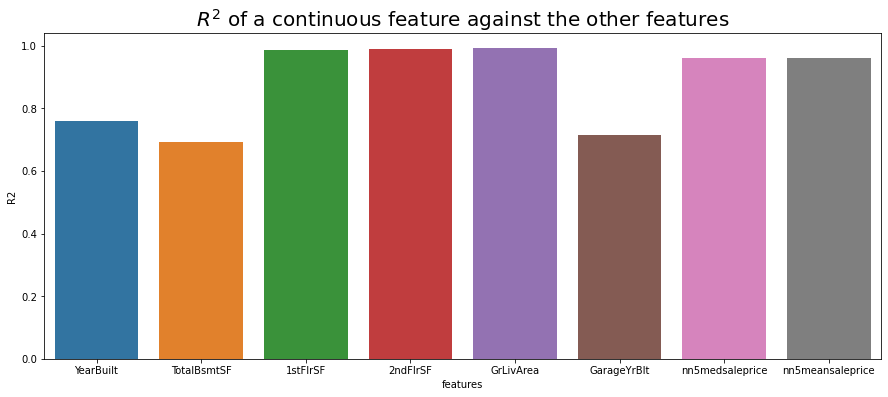

In [110]:
plt.figure(figsize = (15, 6))
sns.barplot(x='index', y='R2', data=pd.DataFrame(scores, index=['R2']).T.reset_index())
plt.xlabel('features')
plt.title('$R^2$ of a continuous feature against the other features', size = 20);

In [22]:
# Drop GarageYrBlt since its R2, p-value for F-test, and mutual information score is worse than YearBuilt. Lasso also
# suggests its less important than YearBuilt.
# Drop 1stFlrSF and 2ndFlrSF since their R2, p-value for F-test and mutual information scores are worse than GrLivArea. 
# Drop nn5medsaleprice since its p-value for F-test and mutual information score is slightly worse than nn5meansaleprice.

# --- Final Regression ---

In [32]:
housing_temp = housing[['MSSubClass', 'Neighborhood', 'YearBuilt', 'ExterQual', 'Foundation', 'BsmtQual', 'TotalBsmtSF', 
                        'HeatingQC', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'KitchenQual', 'Fireplaces', 'GarageType',
                        'GarageFinish', 'GarageCars', 'nn5meansaleprice', 'LogSalePrice']].copy()

housing_temp['MSSubClass'] = housing_temp['MSSubClass'] == 60
housing_temp['Neighborhood'] = housing_temp['Neighborhood'] == 'NridgHt'
housing_temp['ExterQual'] = housing_temp['ExterQual'] == 'Gd'
housing_temp['Foundation'] = housing_temp['Foundation'] == 'CBlock'
housing_temp['BsmtQual'] = housing_temp['BsmtQual'] == 'Ex'
housing_temp['HeatingQC'] = housing_temp['HeatingQC'] == 'TA'
housing_temp['KitchenQual'] = housing_temp['KitchenQual'] == 'Gd'
housing_temp['GarageType'] = housing_temp['GarageType'] == 'Detchd'
housing_temp['GarageFinish'] = housing_temp['GarageFinish'] == 'Fin'

housing_temp = housing_temp[~housing_temp.isnull().any(axis = 1)].reset_index().drop('index', axis = 1)

In [33]:
regression = LinearRegression()
k5 = KFold(n_splits=5)
train_R2 = []
test_R2 = []

for train_index, test_index in k5.split(housing_temp.loc[:, housing_temp.columns != 'LogSalePrice'], 
                                        housing_temp['LogSalePrice']):
    x_train = housing_temp.loc[:, housing_temp.columns != 'LogSalePrice'].iloc[train_index]
    y_train = housing_temp['LogSalePrice'][train_index]
    x_test = housing_temp.loc[:, housing_temp.columns != 'LogSalePrice'].iloc[test_index]
    y_test = housing_temp['LogSalePrice'][test_index]
    regression.fit(x_train, y_train)
    train_R2.append(regression.score(x_train, y_train))
    test_R2.append(regression.score(x_test, y_test))

print(f'Train R2: {np.array(train_R2).mean(): .3}')
print(f'Test R2: {np.array(test_R2).mean(): .3}')

Train R2:  0.855
Test R2:  0.852


In [34]:
regression.fit(housing_temp.loc[:, housing_temp.columns != 'LogSalePrice'], housing_temp['LogSalePrice'])
print('R2: %.3f'%regression.score(housing_temp.loc[:, housing_temp.columns != 'LogSalePrice'], housing_temp['LogSalePrice']))
pd.concat([pd.DataFrame({'features': housing_temp.columns[:-1].values, 'coefficients': regression.coef_}), 
           pd.DataFrame({'features': ['Intercept'], 'coefficients': regression.intercept_})], axis = 0).reset_index().drop('index', axis = 1)

R2: 0.855


,features,coefficients
0,MSSubClass,-0.017212
1,Neighborhood,-0.001193
2,YearBuilt,0.002108
3,ExterQual,0.004004
4,Foundation,0.021147
5,BsmtQual,0.096119
6,TotalBsmtSF,0.000160
7,HeatingQC,-0.050784
8,GrLivArea,0.000321
9,FullBath,-0.034077


In [35]:
housing_temp = housing_temp[['YearBuilt', 'TotalBsmtSF', 'GrLivArea', 'nn5meansaleprice', 'LogSalePrice']]

In [36]:
regression.fit(housing_temp.loc[:, housing_temp.columns != 'LogSalePrice'], housing_temp['LogSalePrice'])
print('R2: %.3f'%regression.score(housing_temp.loc[:, housing_temp.columns != 'LogSalePrice'], housing_temp['LogSalePrice']))
pd.concat([pd.DataFrame({'features': housing_temp.columns[:-1].values, 'coefficients': regression.coef_}), 
           pd.DataFrame({'features': ['Intercept'], 'coefficients': regression.intercept_})], axis = 0).reset_index().drop('index', axis = 1)

R2: 0.829


,features,coefficients
0,YearBuilt,0.002537
1,TotalBsmtSF,0.000197
2,GrLivArea,0.000308
3,nn5meansaleprice,0.411127
4,Intercept,1.408557


# APPENDIX: R2 CALCULATION FOR EACH FEATURE FROM INITIAL QUALITATIVE EDA

# nn5medsaleprice

In [99]:
housing_temp = housing[~housing['nn5medsaleprice'].isnull()][['LogSalePrice', 'nn5medsaleprice']]
housing_temp

,LogSalePrice,nn5medsaleprice
0,11.744037,11.849398
1,11.845820,11.643954
2,11.735269,11.225243
3,11.643954,11.669929
4,12.332705,12.128111
...,...,...
2490,11.703546,11.827736
2491,11.846536,12.083905
2492,11.884489,11.911702
2493,12.289954,12.180755


In [100]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.662
Test R2: 0.703


# nn5meansaleprice

In [101]:
housing_temp = housing[~housing['nn5meansaleprice'].isnull()][['LogSalePrice', 'nn5meansaleprice']]
housing_temp

,LogSalePrice,nn5meansaleprice
0,11.744037,11.800358
1,11.845820,11.872039
2,11.735269,11.165635
3,11.643954,11.695414
4,12.332705,12.142067
...,...,...
2490,11.703546,11.753830
2491,11.846536,12.084470
2492,11.884489,12.073683
2493,12.289954,12.210214


In [102]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.668
Test R2: 0.697


# MSSubClass

In [29]:
MSSubClass = pd.get_dummies(housing['MSSubClass'], prefix = 'MSSubClass')
MSSubClass.drop('MSSubClass_' + str(housing['MSSubClass'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['LogSalePrice'], MSSubClass], axis = 1)
housing_temp

,LogSalePrice,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190
0,11.744037,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,11.845820,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,11.735269,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,11.643954,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,12.332705,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2490,11.703546,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2491,11.846536,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2492,11.884489,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2493,12.289954,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [30]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.329
Test R2: 0.293


# HouseStyle

In [31]:
HouseStyle = pd.get_dummies(housing['HouseStyle'], prefix = 'HouseStyle')
HouseStyle.drop('HouseStyle_' + str(housing['HouseStyle'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['LogSalePrice'], HouseStyle], axis = 1)
housing_temp

,LogSalePrice,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl
0,11.744037,0,0,0,0,0,0,0
1,11.845820,0,0,0,0,0,0,0
2,11.735269,0,0,0,0,0,0,0
3,11.643954,0,0,0,0,1,0,0
4,12.332705,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
2490,11.703546,0,1,0,0,0,0,0
2491,11.846536,0,0,0,0,0,0,0
2492,11.884489,0,0,0,0,1,0,0
2493,12.289954,0,0,0,0,1,0,0


In [32]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.085
Test R2: 0.083


# BldgType

In [33]:
BldgType = pd.get_dummies(housing['BldgType'], prefix = 'BldgType')
BldgType.drop('BldgType_' + str(housing['BldgType'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['LogSalePrice'], BldgType], axis = 1)
housing_temp

,LogSalePrice,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE
0,11.744037,0,0,0,0
1,11.845820,0,0,0,1
2,11.735269,0,0,0,0
3,11.643954,0,0,0,0
4,12.332705,0,0,0,0
...,...,...,...,...,...
2490,11.703546,0,0,0,0
2491,11.846536,0,0,0,0
2492,11.884489,0,1,0,0
2493,12.289954,0,0,0,0


In [34]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.039
Test R2: 0.030


# MSZoning

In [35]:
MSZoning = pd.get_dummies(housing['MSZoning'], prefix = 'MSZoning')
MSZoning.drop('MSZoning_' + str(housing['MSZoning'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['LogSalePrice'], MSZoning], axis = 1)
housing_temp

,LogSalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RM
0,11.744037,0,0,0,0,0
1,11.845820,0,0,0,0,0
2,11.735269,1,0,0,0,0
3,11.643954,0,0,0,0,0
4,12.332705,0,0,0,0,0
...,...,...,...,...,...,...
2490,11.703546,0,0,0,0,0
2491,11.846536,0,0,0,0,0
2492,11.884489,0,0,0,1,0
2493,12.289954,0,0,0,0,0


In [36]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.178
Test R2: 0.171


# LandContour

In [37]:
LandContour = pd.get_dummies(housing['LandContour'], prefix = 'LandContour')
LandContour.drop('LandContour_' + str(housing['LandContour'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['LogSalePrice'], LandContour], axis = 1)
housing_temp

,LogSalePrice,LandContour_Bnk,LandContour_HLS,LandContour_Low
0,11.744037,0,0,0
1,11.845820,0,0,0
2,11.735269,0,0,0
3,11.643954,0,0,0
4,12.332705,0,0,0
...,...,...,...,...
2490,11.703546,0,0,0
2491,11.846536,0,0,0
2492,11.884489,0,1,0
2493,12.289954,0,0,0


In [38]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.020
Test R2: 0.041


# LotConfig

In [39]:
LotConfig = pd.get_dummies(housing['LotConfig'], prefix = 'LotConfig')
LotConfig.drop('LotConfig_' + str(housing['LotConfig'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['LogSalePrice'], LotConfig], axis = 1)
housing_temp

,LogSalePrice,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3
0,11.744037,1,0,0,0
1,11.845820,0,0,0,0
2,11.735269,0,0,0,0
3,11.643954,1,0,0,0
4,12.332705,0,0,0,0
...,...,...,...,...,...
2490,11.703546,0,0,0,0
2491,11.846536,0,1,0,0
2492,11.884489,0,0,0,0
2493,12.289954,0,0,0,0


In [40]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.019
Test R2: 0.011


# Neighborhood

In [41]:
Neighborhood = pd.get_dummies(housing['Neighborhood'], prefix = 'Neighborhood')
Neighborhood.drop('Neighborhood_' + str(housing['Neighborhood'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['LogSalePrice'], Neighborhood], axis = 1)
housing_temp

,LogSalePrice,Neighborhood_Blmngtn,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0,11.744037,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,11.845820,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,11.735269,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,11.643954,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,12.332705,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2490,11.703546,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2491,11.846536,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2492,11.884489,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2493,12.289954,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.578
Test R2: 0.589


# Condition1

In [43]:
Condition1 = pd.get_dummies(housing['Condition1'], prefix = 'Condition1')
Condition1.drop('Condition1_' + str(housing['Condition1'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['LogSalePrice'], Condition1], axis = 1)
housing_temp

,LogSalePrice,Condition1_Artery,Condition1_Feedr,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn
0,11.744037,0,0,0,0,0,0,0,0
1,11.845820,0,0,0,0,0,0,0,0
2,11.735269,0,0,0,0,0,0,0,0
3,11.643954,0,0,0,0,0,0,0,0
4,12.332705,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2490,11.703546,0,0,0,0,0,0,0,0
2491,11.846536,0,0,0,0,0,0,0,0
2492,11.884489,0,0,0,0,0,0,0,0
2493,12.289954,0,0,0,0,0,0,0,0


In [44]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.066
Test R2: 0.025


# YearBuilt

In [45]:
housing_temp = housing[['LogSalePrice', 'YearBuilt']]
housing_temp

,LogSalePrice,YearBuilt
0,11.744037,1939
1,11.845820,1984
2,11.735269,1930
3,11.643954,1900
4,12.332705,2001
...,...,...
2490,11.703546,1916
2491,11.846536,1955
2492,11.884489,1949
2493,12.289954,2000


In [46]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.349
Test R2: 0.376


# YearRemodAdd

In [47]:
housing_temp = housing.copy()
housing_temp['Remod'] = (housing_temp['YearBuilt'] != housing_temp['YearRemodAdd']).map(int)
housing_temp = housing_temp[['LogSalePrice', 'Remod']]
housing_temp

,LogSalePrice,Remod
0,11.744037,1
1,11.845820,0
2,11.735269,1
3,11.643954,1
4,12.332705,0
...,...,...
2490,11.703546,1
2491,11.846536,0
2492,11.884489,1
2493,12.289954,0


In [48]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.009
Test R2: 0.010


# RoofStyle

In [49]:
RoofStyle = pd.get_dummies(housing['RoofStyle'], prefix = 'RoofStyle')
RoofStyle.drop('RoofStyle_' + str(housing['RoofStyle'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['LogSalePrice'], RoofStyle], axis = 1)
housing_temp

,LogSalePrice,RoofStyle_Flat,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed
0,11.744037,0,0,0,0,0
1,11.845820,0,0,0,0,0
2,11.735269,0,0,1,0,0
3,11.643954,0,0,0,0,0
4,12.332705,0,0,0,0,0
...,...,...,...,...,...,...
2490,11.703546,0,0,0,0,0
2491,11.846536,0,0,1,0,0
2492,11.884489,0,0,0,0,0
2493,12.289954,0,0,0,0,0


In [50]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.044
Test R2: 0.045


# Exterior1st, Exterior2nd

In [51]:
housing_temp = housing.copy()
housing_temp['Exterior2nd'].replace('Brk Cmn', 'BrkComm', inplace = True)
housing_temp['Exterior2nd'].replace('CmentBd', 'CemntBd', inplace = True)
housing_temp['Exterior2nd'].replace('Wd Shng', 'WdShing', inplace= True)
housing_temp['Exterior'] = housing_temp['Exterior1st'] + '_' + housing_temp['Exterior2nd'] 
housing_temp = housing_temp[['LogSalePrice', 'Exterior']]
Exterior = pd.get_dummies(housing_temp['Exterior'], prefix = 'Exterior')
Exterior.drop('Exterior_' + str(housing_temp['Exterior'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['LogSalePrice'], Exterior], axis = 1)
housing_temp

,LogSalePrice,Exterior_AsbShng_AsbShng,Exterior_AsbShng_CemntBd,Exterior_AsbShng_Plywood,Exterior_AsbShng_Stucco,Exterior_AsbShng_Wd Sdng,Exterior_AsphShn_AsphShn,Exterior_BrkComm_BrkComm,Exterior_BrkComm_Stucco,Exterior_BrkComm_Wd Sdng,Exterior_BrkFace_AsbShng,Exterior_BrkFace_BrkFace,Exterior_BrkFace_HdBoard,Exterior_BrkFace_MetalSd,Exterior_BrkFace_Plywood,Exterior_BrkFace_Stone,Exterior_BrkFace_Stucco,Exterior_BrkFace_Wd Sdng,Exterior_CBlock_CBlock,Exterior_CemntBd_CemntBd,Exterior_CemntBd_Wd Sdng,Exterior_CemntBd_WdShing,Exterior_HdBoard_AsphShn,Exterior_HdBoard_BrkFace,Exterior_HdBoard_HdBoard,Exterior_HdBoard_ImStucc,Exterior_HdBoard_MetalSd,Exterior_HdBoard_Plywood,Exterior_HdBoard_Stucco,Exterior_HdBoard_Wd Sdng,Exterior_HdBoard_WdShing,Exterior_MetalSd_AsphShn,Exterior_MetalSd_CBlock,Exterior_MetalSd_HdBoard,Exterior_MetalSd_MetalSd,Exterior_MetalSd_Stucco,Exterior_MetalSd_VinylSd,Exterior_MetalSd_Wd Sdng,Exterior_MetalSd_WdShing,Exterior_Plywood_BrkComm,Exterior_Plywood_CBlock,Exterior_Plywood_HdBoard,Exterior_Plywood_ImStucc,Exterior_Plywood_Plywood,Exterior_Plywood_VinylSd,Exterior_Plywood_Wd Sdng,Exterior_Plywood_WdShing,Exterior_PreCast_PreCast,Exterior_Stucco_BrkFace,Exterior_Stucco_CemntBd,Exterior_Stucco_Plywood,Exterior_Stucco_Stone,Exterior_Stucco_Stucco,Exterior_Stucco_Wd Sdng,Exterior_Stucco_WdShing,Exterior_VinylSd_AsbShng,Exterior_VinylSd_HdBoard,Exterior_VinylSd_MetalSd,Exterior_VinylSd_Plywood,Exterior_VinylSd_Wd Sdng,Exterior_VinylSd_WdShing,Exterior_Wd Sdng_AsbShng,Exterior_Wd Sdng_BrkFace,Exterior_Wd Sdng_HdBoard,Exterior_Wd Sdng_ImStucc,Exterior_Wd Sdng_MetalSd,Exterior_Wd Sdng_Plywood,Exterior_Wd Sdng_Stucco,Exterior_Wd Sdng_VinylSd,Exterior_Wd Sdng_Wd Sdng,Exterior_Wd Sdng_WdShing,Exterior_WdShing_HdBoard,Exterior_WdShing_Plywood,Exterior_WdShing_Stucco,Exterior_WdShing_Wd Sdng,Exterior_WdShing_WdShing
0,11.744037,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,11.845820,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,11.735269,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,11.643954,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,12.332705,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2490,11.703546,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2491,11.846536,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2492,11.884489,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2493,12.289954,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [52]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.187
Test R2:-42265752479102272251363328.000


In [53]:
# Weird Test R2 due to class imbalance

# MasVnrType

In [54]:
MasVnrType = pd.get_dummies(housing[~housing['MasVnrType'].isnull()]['MasVnrType'], prefix = 'MasVnrType')
MasVnrType.drop('MasVnrType_' + str(housing[~housing['MasVnrType'].isnull()]['MasVnrType'].mode()[0]),
                axis = 1, inplace = True)
housing_temp = pd.concat([housing[~housing['MasVnrType'].isnull()]['LogSalePrice'], MasVnrType], axis = 1)
housing_temp

,LogSalePrice,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_Stone
0,11.744037,0,0,0
1,11.845820,0,1,0
2,11.735269,0,0,0
3,11.643954,0,0,0
4,12.332705,0,0,0
...,...,...,...,...
2490,11.703546,0,0,0
2491,11.846536,0,0,0
2492,11.884489,0,0,0
2493,12.289954,0,1,0


In [55]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.179
Test R2: 0.161


# MasVnrArea

In [56]:
housing_temp = housing[~housing['MasVnrArea'].isnull()][['LogSalePrice', 'MasVnrArea']]
housing_temp

,LogSalePrice,MasVnrArea
0,11.744037,0.0
1,11.845820,149.0
2,11.735269,0.0
3,11.643954,0.0
4,12.332705,0.0
...,...,...
2490,11.703546,0.0
2491,11.846536,0.0
2492,11.884489,0.0
2493,12.289954,144.0


In [57]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.210
Test R2: 0.162


# ExterQual

In [58]:
ExterQual = pd.get_dummies(housing['ExterQual'], prefix = 'ExterQual')
ExterQual.drop('ExterQual_' + str(housing['ExterQual'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['LogSalePrice'], ExterQual], axis = 1)
housing_temp

,LogSalePrice,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd
0,11.744037,0,0,0
1,11.845820,0,0,1
2,11.735269,0,0,1
3,11.643954,0,0,1
4,12.332705,0,0,1
...,...,...,...,...
2490,11.703546,0,0,0
2491,11.846536,0,0,0
2492,11.884489,0,0,0
2493,12.289954,0,0,1


In [59]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.436
Test R2: 0.481


# ExterCond

In [60]:
ExterCond = pd.get_dummies(housing['ExterCond'], prefix = 'ExterCond')
ExterCond.drop('ExterCond_' + str(housing['ExterCond'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['LogSalePrice'], ExterCond], axis = 1)
housing_temp

,LogSalePrice,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po
0,11.744037,0,0,0,0
1,11.845820,0,0,0,0
2,11.735269,0,0,0,0
3,11.643954,0,0,1,0
4,12.332705,0,0,0,0
...,...,...,...,...,...
2490,11.703546,0,0,0,0
2491,11.846536,0,0,0,0
2492,11.884489,0,0,0,0
2493,12.289954,0,0,0,0


In [61]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.041
Test R2: 0.024


# Foundation

In [62]:
Foundation = pd.get_dummies(housing['Foundation'], prefix = 'Foundation')
Foundation.drop('Foundation_' + str(housing['Foundation'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['LogSalePrice'], Foundation], axis = 1)
housing_temp

,LogSalePrice,Foundation_BrkTil,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood
0,11.744037,0,0,0,0,0
1,11.845820,0,0,0,0,0
2,11.735269,1,0,0,0,0
3,11.643954,1,0,0,0,0
4,12.332705,0,1,0,0,0
...,...,...,...,...,...,...
2490,11.703546,1,0,0,0,0
2491,11.846536,0,0,1,0,0
2492,11.884489,0,0,0,0,0
2493,12.289954,0,1,0,0,0


In [63]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.309
Test R2: 0.293


# BsmtQual

In [64]:
BsmtQual = pd.get_dummies(housing[~housing['BsmtQual'].isnull()]['BsmtQual'], prefix = 'BsmtQual')
BsmtQual.drop('BsmtQual_' + str(housing[~housing['BsmtQual'].isnull()]['BsmtQual'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing[~housing['BsmtQual'].isnull()]['LogSalePrice'], BsmtQual], axis = 1)
housing_temp

,LogSalePrice,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_Po
0,11.744037,0,0,0,0
1,11.845820,0,0,1,0
2,11.735269,0,0,0,0
3,11.643954,0,1,0,0
4,12.332705,0,0,1,0
...,...,...,...,...,...
2489,12.188418,0,0,1,0
2490,11.703546,0,0,0,0
2492,11.884489,0,0,0,0
2493,12.289954,0,0,1,0


In [65]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.431
Test R2: 0.493


# BsmtCond

In [66]:
BsmtCond = pd.get_dummies(housing[~housing['BsmtCond'].isnull()]['BsmtCond'], prefix = 'BsmtCond')
BsmtCond.drop('BsmtCond_' + str(housing[~housing['BsmtCond'].isnull()]['BsmtCond'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing[~housing['BsmtCond'].isnull()]['LogSalePrice'], BsmtCond], axis = 1)
housing_temp

,LogSalePrice,BsmtCond_Ex,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po
0,11.744037,0,0,0,0
1,11.845820,0,0,0,0
2,11.735269,0,0,0,0
3,11.643954,0,0,0,0
4,12.332705,0,0,0,0
...,...,...,...,...,...
2489,12.188418,0,0,0,0
2490,11.703546,0,0,0,0
2492,11.884489,0,0,0,0
2493,12.289954,0,0,0,0


In [67]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.058
Test R2: 0.022


# BsmtFinType1

In [68]:
BsmtFinType1 = pd.get_dummies(housing[~housing['BsmtFinType1'].isnull()]['BsmtFinType1'], prefix = 'BsmtFinType1')
BsmtFinType1.drop('BsmtFinType1_' + str(housing[~housing['BsmtFinType1'].isnull()]['BsmtFinType1'].mode()[0]),
                  axis = 1, inplace = True)
housing_temp = pd.concat([housing[~housing['BsmtFinType1'].isnull()]['LogSalePrice'], BsmtFinType1], axis = 1)
housing_temp

,LogSalePrice,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf
0,11.744037,0,0,0,1,0
1,11.845820,0,0,0,0,0
2,11.735269,1,0,0,0,0
3,11.643954,0,0,0,0,1
4,12.332705,0,0,0,0,0
...,...,...,...,...,...,...
2489,12.188418,0,0,0,0,1
2490,11.703546,0,0,0,0,1
2492,11.884489,0,1,0,0,0
2493,12.289954,0,0,0,0,0


In [69]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.226
Test R2: 0.196


# BsmtFinSF1

In [70]:
housing_temp = housing[(~housing['BsmtFinSF1'].isnull()) & housing['BsmtFinSF1'] != 0][['LogSalePrice', 'BsmtFinSF1']]
housing_temp

,LogSalePrice,BsmtFinSF1
0,11.744037,238.0
1,11.845820,552.0
2,11.735269,737.0
4,12.332705,643.0
8,11.831379,647.0
...,...,...
2486,11.652687,890.0
2488,11.773750,574.0
2492,11.884489,284.0
2493,12.289954,841.0


In [71]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.274
Test R2: 0.231


# TotalBsmtSF

In [72]:
housing_temp = housing[(~housing['TotalBsmtSF'].isnull()) & housing['TotalBsmtSF'] != 0][['LogSalePrice', 'TotalBsmtSF']]
housing_temp

,LogSalePrice,TotalBsmtSF
0,11.744037,856.0
1,11.845820,1049.0
2,11.735269,837.0
3,11.643954,405.0
4,12.332705,810.0
...,...,...
2489,12.188418,796.0
2490,11.703546,952.0
2492,11.884489,1001.0
2493,12.289954,985.0


In [73]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.398
Test R2: 0.421


# HeatingQC

In [74]:
HeatingQC = pd.get_dummies(housing['HeatingQC'], prefix = 'HeatingQC')
HeatingQC.drop('HeatingQC_' + str(housing['HeatingQC'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['LogSalePrice'], HeatingQC], axis = 1)
housing_temp

,LogSalePrice,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA
0,11.744037,0,0,0,1
1,11.845820,0,0,0,1
2,11.735269,0,0,0,0
3,11.643954,0,1,0,0
4,12.332705,0,0,0,0
...,...,...,...,...,...
2490,11.703546,1,0,0,0
2491,11.846536,0,0,0,0
2492,11.884489,0,0,0,1
2493,12.289954,0,0,0,0


In [75]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.220
Test R2: 0.259


# CentralAir

In [76]:
housing_temp = housing.copy()
housing_temp['CentralAir'] = (housing_temp['CentralAir'] == 'Y').map(int)
housing_temp = housing_temp[['LogSalePrice', 'CentralAir']]
housing_temp

,LogSalePrice,CentralAir
0,11.744037,1
1,11.845820,1
2,11.735269,1
3,11.643954,1
4,12.332705,1
...,...,...
2490,11.703546,0
2491,11.846536,1
2492,11.884489,0
2493,12.289954,1


In [77]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.127
Test R2: 0.104


# Electrical

In [78]:
Electrical = pd.get_dummies(housing[~housing['Electrical'].isnull()]['Electrical'], prefix = 'Electrical')
Electrical.drop('Electrical_' + str(housing[~housing['Electrical'].isnull()]['Electrical'].mode()[0]),
                axis = 1, inplace = True)
housing_temp = pd.concat([housing[~housing['Electrical'].isnull()]['LogSalePrice'], Electrical], axis = 1)
housing_temp

,LogSalePrice,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP
0,11.744037,0,0,0
1,11.845820,0,0,0
2,11.735269,0,0,0
3,11.643954,0,0,0
4,12.332705,0,0,0
...,...,...,...,...
2490,11.703546,0,1,0
2491,11.846536,1,0,0
2492,11.884489,1,0,0
2493,12.289954,0,0,0


In [79]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.082
Test R2: 0.092


# 1stFlorSF

In [80]:
housing_temp = housing[['LogSalePrice', '1stFlrSF']]
housing_temp

,LogSalePrice,1stFlrSF
0,11.744037,856
1,11.845820,1049
2,11.735269,1001
3,11.643954,717
4,12.332705,810
...,...,...
2490,11.703546,952
2491,11.846536,1733
2492,11.884489,1001
2493,12.289954,985


In [81]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.394
Test R2: 0.396


# 2ndFlrSF

In [82]:
housing_temp = housing[housing['2ndFlrSF'] != 0][['LogSalePrice', '2ndFlrSF']]
housing_temp

,LogSalePrice,2ndFlrSF
3,11.643954,322
4,12.332705,855
5,12.198544,1427
10,11.820410,650
14,12.001505,794
...,...,...
2484,12.128111,683
2489,12.188418,918
2492,11.884489,1001
2493,12.289954,857


In [83]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.467
Test R2: 0.473


# GrLivArea

In [84]:
housing_temp = housing[['LogSalePrice', 'GrLivArea']]
housing_temp

,LogSalePrice,GrLivArea
0,11.744037,856
1,11.845820,1049
2,11.735269,1001
3,11.643954,1039
4,12.332705,1665
...,...,...
2490,11.703546,952
2491,11.846536,1733
2492,11.884489,2002
2493,12.289954,1842


In [85]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.535
Test R2: 0.514


# BsmtFullBath

In [86]:
BsmtFullBath = pd.get_dummies(housing[~housing['BsmtFullBath'].isnull()]['BsmtFullBath'], prefix = 'BsmtFullBath')
BsmtFullBath.drop('BsmtFullBath_' + str(housing[~housing['BsmtFullBath'].isnull()]['BsmtFullBath'].mode()[0]),
                  axis = 1, inplace = True)
housing_temp = pd.concat([housing[~housing['BsmtFullBath'].isnull()]['LogSalePrice'], BsmtFullBath], axis = 1)
housing_temp

,LogSalePrice,BsmtFullBath_1.0,BsmtFullBath_2.0,BsmtFullBath_3.0
0,11.744037,1,0,0
1,11.845820,1,0,0
2,11.735269,0,0,0
3,11.643954,0,0,0
4,12.332705,1,0,0
...,...,...,...,...
2490,11.703546,0,0,0
2491,11.846536,0,0,0
2492,11.884489,0,0,0
2493,12.289954,1,0,0


In [87]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.087
Test R2: 0.065


# FullBath

In [88]:
FullBath = pd.get_dummies(housing['FullBath'], prefix = 'FullBath')
FullBath.drop('FullBath_' + str(housing['FullBath'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['LogSalePrice'], FullBath], axis = 1)
housing_temp

,LogSalePrice,FullBath_0,FullBath_1,FullBath_3,FullBath_4
0,11.744037,0,1,0,0
1,11.845820,0,0,0,0
2,11.735269,0,1,0,0
3,11.643954,0,1,0,0
4,12.332705,0,0,0,0
...,...,...,...,...,...
2490,11.703546,0,1,0,0
2491,11.846536,0,0,0,0
2492,11.884489,0,0,0,0
2493,12.289954,0,0,0,0


In [89]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.329
Test R2: 0.361


# HalfBath

In [90]:
HalfBath = pd.get_dummies(housing['HalfBath'], prefix = 'HalfBath')
HalfBath.drop('HalfBath_' + str(housing['HalfBath'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['LogSalePrice'], HalfBath], axis = 1)
housing_temp

,LogSalePrice,HalfBath_1,HalfBath_2
0,11.744037,0,0
1,11.845820,0,0
2,11.735269,0,0
3,11.643954,0,0
4,12.332705,1,0
...,...,...,...
2490,11.703546,0,0
2491,11.846536,0,0
2492,11.884489,0,0
2493,12.289954,1,0


In [91]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.111
Test R2: 0.074


# BedroomAbvGr

In [92]:
BedroomAbvGr = pd.get_dummies(housing['BedroomAbvGr'], prefix = 'BedroomAbvGr')
BedroomAbvGr.drop('BedroomAbvGr_' + str(housing['BedroomAbvGr'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['LogSalePrice'], BedroomAbvGr], axis = 1)
housing_temp

,LogSalePrice,BedroomAbvGr_0,BedroomAbvGr_1,BedroomAbvGr_2,BedroomAbvGr_4,BedroomAbvGr_5,BedroomAbvGr_6
0,11.744037,0,0,1,0,0,0
1,11.845820,0,0,1,0,0,0
2,11.735269,0,0,1,0,0,0
3,11.643954,0,0,1,0,0,0
4,12.332705,0,0,0,0,0,0
...,...,...,...,...,...,...,...
2490,11.703546,0,0,1,0,0,0
2491,11.846536,0,0,0,1,0,0
2492,11.884489,0,0,0,1,0,0
2493,12.289954,0,0,0,0,0,0


In [93]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.066
Test R2: 0.047


# TotRmsAbvGrd

In [94]:
TotRmsAbvGrd = pd.get_dummies(housing['TotRmsAbvGrd'], prefix = 'TotRmsAbvGrd')
TotRmsAbvGrd.drop('TotRmsAbvGrd_' + str(housing['TotRmsAbvGrd'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['LogSalePrice'], TotRmsAbvGrd], axis = 1)
housing_temp

,LogSalePrice,TotRmsAbvGrd_2,TotRmsAbvGrd_3,TotRmsAbvGrd_4,TotRmsAbvGrd_5,TotRmsAbvGrd_7,TotRmsAbvGrd_8,TotRmsAbvGrd_9,TotRmsAbvGrd_10,TotRmsAbvGrd_11,TotRmsAbvGrd_12,TotRmsAbvGrd_13
0,11.744037,0,0,1,0,0,0,0,0,0,0,0
1,11.845820,0,0,0,1,0,0,0,0,0,0,0
2,11.735269,0,0,0,1,0,0,0,0,0,0,0
3,11.643954,0,0,0,0,0,0,0,0,0,0,0
4,12.332705,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2490,11.703546,0,0,1,0,0,0,0,0,0,0,0
2491,11.846536,0,0,0,0,0,1,0,0,0,0,0
2492,11.884489,0,0,0,0,0,1,0,0,0,0,0
2493,12.289954,0,0,0,0,1,0,0,0,0,0,0


In [95]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.275
Test R2: 0.259


# KitchenQual

In [96]:
KitchenQual = pd.get_dummies(housing['KitchenQual'], prefix = 'KitchenQual')
KitchenQual.drop('KitchenQual_' + str(housing['KitchenQual'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['LogSalePrice'], KitchenQual], axis = 1)
housing_temp

,LogSalePrice,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_Po
0,11.744037,0,0,0,0
1,11.845820,0,0,1,0
2,11.735269,0,0,1,0
3,11.643954,0,0,0,0
4,12.332705,0,0,1,0
...,...,...,...,...,...
2490,11.703546,0,1,0,0
2491,11.846536,0,0,0,0
2492,11.884489,0,0,0,0
2493,12.289954,0,0,1,0


In [97]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.421
Test R2: 0.434


# Fireplaces

In [98]:
Fireplaces = pd.get_dummies(housing['Fireplaces'], prefix = 'Fireplaces')
Fireplaces.drop('Fireplaces_' + str(housing['Fireplaces'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['LogSalePrice'], Fireplaces], axis = 1)
housing_temp

,LogSalePrice,Fireplaces_1,Fireplaces_2,Fireplaces_3,Fireplaces_4
0,11.744037,1,0,0,0
1,11.845820,0,0,0,0
2,11.735269,0,0,0,0
3,11.643954,0,0,0,0
4,12.332705,0,0,0,0
...,...,...,...,...,...
2490,11.703546,1,0,0,0
2491,11.846536,1,0,0,0
2492,11.884489,0,0,0,0
2493,12.289954,1,0,0,0


In [99]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.256
Test R2: 0.295


# GarageType

In [100]:
GarageType = pd.get_dummies(housing[~housing['GarageType'].isnull()]['GarageType'], prefix = 'GarageType')
GarageType.drop('GarageType_' + str(housing[~housing['GarageType'].isnull()]['GarageType'].mode()[0]),
                axis = 1, inplace = True)
housing_temp = pd.concat([housing[~housing['GarageType'].isnull()]['LogSalePrice'], GarageType], axis = 1)
housing_temp

,LogSalePrice,GarageType_2Types,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd
0,11.744037,0,0,0,0,1
1,11.845820,0,0,0,0,0
2,11.735269,0,0,0,0,1
3,11.643954,0,0,0,0,1
4,12.332705,0,0,0,0,0
...,...,...,...,...,...,...
2490,11.703546,0,0,0,0,1
2491,11.846536,0,0,0,0,0
2492,11.884489,1,0,0,0,0
2493,12.289954,0,0,0,0,0


In [101]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.266
Test R2: 0.236


# GarageYrBlt

In [102]:
housing_temp = housing[(~housing['GarageYrBlt'].isnull()) & (housing['GarageYrBlt'] != 0)][['LogSalePrice', 'GarageYrBlt']]
housing_temp

,LogSalePrice,GarageYrBlt
0,11.744037,1939.0
1,11.845820,1984.0
2,11.735269,1930.0
3,11.643954,1940.0
4,12.332705,2001.0
...,...,...
2490,11.703546,1916.0
2491,11.846536,1955.0
2492,11.884489,1949.0
2493,12.289954,2000.0


In [103]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.338
Test R2: 0.301


# GarageFinish

In [104]:
GarageFinish = pd.get_dummies(housing[~housing['GarageFinish'].isnull()]['GarageFinish'], prefix = 'GarageFinish')
GarageFinish.drop('GarageFinish_' + str(housing[~housing['GarageFinish'].isnull()]['GarageFinish'].mode()[0]),
                axis = 1, inplace = True)
housing_temp = pd.concat([housing[~housing['GarageFinish'].isnull()]['LogSalePrice'], GarageFinish], axis = 1)
housing_temp

,LogSalePrice,GarageFinish_Fin,GarageFinish_RFn
0,11.744037,0,0
1,11.845820,1,0
2,11.735269,0,0
3,11.643954,0,0
4,12.332705,1,0
...,...,...,...
2490,11.703546,0,0
2491,11.846536,0,0
2492,11.884489,0,0
2493,12.289954,1,0


In [105]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.301
Test R2: 0.295


# GarageCars

In [106]:
GarageCars = pd.get_dummies(housing[~housing['GarageCars'].isnull()]['GarageCars'], prefix = 'GarageCars')
GarageCars.drop('GarageCars_' + str(housing[~housing['GarageCars'].isnull()]['GarageCars'].mode()[0]),
                axis = 1, inplace = True)
housing_temp = pd.concat([housing[~housing['GarageCars'].isnull()]['LogSalePrice'], GarageCars], axis = 1)
housing_temp

,LogSalePrice,GarageCars_0.0,GarageCars_1.0,GarageCars_3.0,GarageCars_4.0,GarageCars_5.0
0,11.744037,0,0,0,0,0
1,11.845820,0,1,0,0,0
2,11.735269,0,1,0,0,0
3,11.643954,0,1,0,0,0
4,12.332705,0,0,0,0,0
...,...,...,...,...,...,...
2490,11.703546,0,1,0,0,0
2491,11.846536,0,0,0,0,0
2492,11.884489,0,0,1,0,0
2493,12.289954,0,0,0,0,0


In [107]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.474
Test R2: 0.497


# GarageArea

In [108]:
housing_temp = housing[(~housing['GarageArea'].isnull()) & (housing['GarageArea'] != 0)][['LogSalePrice', 'GarageArea']]
housing_temp

,LogSalePrice,GarageArea
0,11.744037,399.0
1,11.845820,266.0
2,11.735269,216.0
3,11.643954,281.0
4,12.332705,528.0
...,...,...
2490,11.703546,192.0
2491,11.846536,452.0
2492,11.884489,871.0
2493,12.289954,486.0


In [109]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.373
Test R2: 0.395


# GarageQual

In [110]:
GarageQual = pd.get_dummies(housing[~housing['GarageQual'].isnull()]['GarageQual'], prefix = 'GarageQual')
GarageQual.drop('GarageQual_' + str(housing[~housing['GarageQual'].isnull()]['GarageQual'].mode()[0]),
                axis = 1, inplace = True)
housing_temp = pd.concat([housing[~housing['GarageQual'].isnull()]['LogSalePrice'], GarageQual], axis = 1)
housing_temp

,LogSalePrice,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po
0,11.744037,0,0,0,0
1,11.845820,0,0,0,0
2,11.735269,0,0,0,0
3,11.643954,0,0,0,0
4,12.332705,0,0,0,0
...,...,...,...,...,...
2490,11.703546,0,1,0,0
2491,11.846536,0,0,0,0
2492,11.884489,0,0,0,0
2493,12.289954,0,0,0,0


In [111]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.061
Test R2: 0.064


# GarageCond

In [112]:
GarageCond = pd.get_dummies(housing[~housing['GarageCond'].isnull()]['GarageCond'], prefix = 'GarageCond')
GarageCond.drop('GarageCond_' + str(housing[~housing['GarageCond'].isnull()]['GarageCond'].mode()[0]),
                axis = 1, inplace = True)
housing_temp = pd.concat([housing[~housing['GarageCond'].isnull()]['LogSalePrice'], GarageCond], axis = 1)
housing_temp

,LogSalePrice,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po
0,11.744037,0,0,0,0
1,11.845820,0,0,0,0
2,11.735269,0,0,0,1
3,11.643954,0,0,0,0
4,12.332705,0,0,0,0
...,...,...,...,...,...
2490,11.703546,0,0,0,1
2491,11.846536,0,0,0,0
2492,11.884489,0,0,0,0
2493,12.289954,0,0,0,0


In [113]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.050
Test R2: 0.091


# PavedDrive

In [114]:
PavedDrive = pd.get_dummies(housing['PavedDrive'], prefix = 'PavedDrive')
PavedDrive.drop('PavedDrive_' + str(housing['PavedDrive'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['LogSalePrice'], PavedDrive], axis = 1)
housing_temp

,LogSalePrice,PavedDrive_N,PavedDrive_P
0,11.744037,0,0
1,11.845820,0,0
2,11.735269,1,0
3,11.643954,1,0
4,12.332705,0,0
...,...,...,...
2490,11.703546,0,1
2491,11.846536,0,0
2492,11.884489,0,0
2493,12.289954,0,0


In [115]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.126
Test R2: 0.104


# MoSold

In [116]:
MoSold = pd.get_dummies(housing['MoSold'], prefix = 'MoSold')
MoSold.drop('MoSold_' + str(housing['MoSold'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['LogSalePrice'], MoSold], axis = 1)
housing_temp

,LogSalePrice,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12
0,11.744037,0,0,1,0,0,0,0,0,0,0,0
1,11.845820,0,1,0,0,0,0,0,0,0,0,0
2,11.735269,0,0,0,0,0,0,0,0,0,1,0
3,11.643954,0,0,0,0,1,0,0,0,0,0,0
4,12.332705,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2490,11.703546,0,0,0,0,1,0,0,0,0,0,0
2491,11.846536,0,0,0,0,0,0,0,0,0,0,0
2492,11.884489,0,0,0,0,0,0,1,0,0,0,0
2493,12.289954,0,0,0,0,0,1,0,0,0,0,0


In [117]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.005
Test R2:-0.007


# SaleType

In [118]:
SaleType = pd.get_dummies(housing['SaleType'], prefix = 'SaleType')
SaleType.drop('SaleType_' + str(housing['SaleType'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['LogSalePrice'], SaleType], axis = 1)
housing_temp

,LogSalePrice,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_VWD
0,11.744037,0,0,0,0,0,0,0,0,0
1,11.845820,0,0,0,0,0,0,0,0,0
2,11.735269,0,0,0,0,0,0,0,0,0
3,11.643954,0,0,0,0,0,0,0,0,0
4,12.332705,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2490,11.703546,0,0,0,0,0,0,0,0,0
2491,11.846536,0,0,0,0,0,0,0,0,0
2492,11.884489,0,0,0,0,0,0,0,0,0
2493,12.289954,0,0,0,0,0,0,0,0,0


In [119]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.063
Test R2: 0.080


# SaleCondition

In [120]:
SaleCondition = pd.get_dummies(housing['SaleCondition'], prefix = 'SaleCondition')
SaleCondition.drop('SaleCondition_' + str(housing['SaleCondition'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['LogSalePrice'], SaleCondition], axis = 1)
housing_temp

,LogSalePrice,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Partial
0,11.744037,0,0,0,0,0
1,11.845820,0,0,0,0,0
2,11.735269,0,0,0,0,0
3,11.643954,0,0,0,0,0
4,12.332705,0,0,0,0,0
...,...,...,...,...,...,...
2490,11.703546,0,0,0,0,0
2491,11.846536,0,0,0,0,0
2492,11.884489,0,0,0,0,0
2493,12.289954,0,0,0,0,0


In [121]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.051
Test R2: 0.080
